# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [13]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import StratifiedKFold
import codecs

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


800 Files -> 640 MB in Folder, the first 800 from the folder "train/0"

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


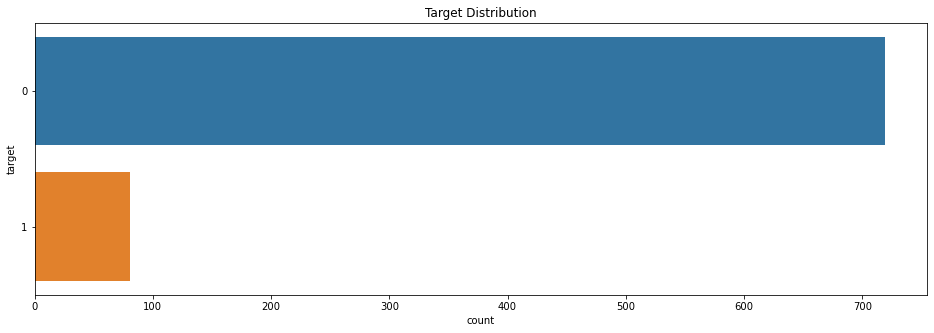

In [14]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");

In [6]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets): 
        self.image_paths = image_paths
        self.targets = targets

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [7]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [8]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [9]:
baseline_name = 'efficientnet-b1' # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name: './checkpoint/efficientnet-b1-dbc7070a.pth' # Checkpoint?
}
models = []
device = "cuda"
epochs = 6
Batch_Size = 8
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
fold = 0

for train_index, test_index in skf.split(X, Y):
    
    model = enetv2(baseline_name, out_dim=1)
    model.to(device)

    train_images, valid_images = X[train_index], X[test_index]
    train_targets, valid_targets = Y[train_index], Y[test_index]

    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
    

    best_roc_auc = 0
    for epoch in range(epochs):
        if epoch == 3:
            for param_group in optimizer.param_groups:
                param_group["lr"] = 1e-4
        if epoch == 4:
            for param_group in optimizer.param_groups:
                param_group["lr"] = 1e-6
        
        train(train_loader, model, optimizer, device=device)
        predictions, valid_targets = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}")
        
        with codecs.open('log.log', 'a') as up:
            up.write(f"Fold={fold}, Epoch={epoch}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        if roc_auc > best_roc_auc:        
            torch.save(model.state_dict(), baseline_name + '-' + str(fold) + '-' + str(epoch) + '.pt')
            best_roc_auc = roc_auc
            
    torch.save(model.state_dict(),baseline_name + '-' + str(fold) + '.pt')
    models.append(model)
    fold += 1

Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.68it/s]


Epoch=0, Valid ROC AUC=0.4040798611111111


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.63it/s]


Epoch=1, Valid ROC AUC=0.46744791666666663


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.87it/s]


Epoch=2, Valid ROC AUC=0.6371527777777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.90it/s]


Epoch=3, Valid ROC AUC=0.609375


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.54it/s]


Epoch=4, Valid ROC AUC=0.5967881944444444


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.58it/s]


Epoch=5, Valid ROC AUC=0.5824652777777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.70it/s]


Epoch=0, Valid ROC AUC=0.5707465277777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.57it/s]


Epoch=1, Valid ROC AUC=0.5538194444444444


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.55it/s]


Epoch=2, Valid ROC AUC=0.4774305555555556


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.35it/s]


Epoch=3, Valid ROC AUC=0.5473090277777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.55it/s]


Epoch=4, Valid ROC AUC=0.5533854166666666


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.54it/s]


Epoch=5, Valid ROC AUC=0.5481770833333334


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.25it/s]


Epoch=0, Valid ROC AUC=0.4266493055555555


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.50it/s]


Epoch=1, Valid ROC AUC=0.560763888888889


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.53it/s]


Epoch=2, Valid ROC AUC=0.4661458333333333


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.64it/s]


Epoch=3, Valid ROC AUC=0.3411458333333333


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.13it/s]


Epoch=4, Valid ROC AUC=0.37109375


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.09it/s]


Epoch=5, Valid ROC AUC=0.39236111111111116


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Epoch=0, Valid ROC AUC=0.5026041666666667


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.34it/s]


Epoch=1, Valid ROC AUC=0.5199652777777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.09it/s]


Epoch=2, Valid ROC AUC=0.36414930555555547


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.94it/s]


Epoch=3, Valid ROC AUC=0.3984375


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.92it/s]


Epoch=4, Valid ROC AUC=0.40625


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.35it/s]


Epoch=5, Valid ROC AUC=0.4144965277777778


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.43it/s]


Epoch=0, Valid ROC AUC=0.5359934183463595


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.17it/s]


Epoch=1, Valid ROC AUC=0.4956807897984369


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.48it/s]


Epoch=2, Valid ROC AUC=0.5006170300287947


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.10it/s]


Epoch=3, Valid ROC AUC=0.4903331962155491


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.99it/s]


Epoch=4, Valid ROC AUC=0.4874537227478404


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.10it/s]

Epoch=5, Valid ROC AUC=0.48087206910736324
